<h1 align="center">Práctica 2. Tablas de dispersión</h1>
<h3 style="display:block; margin-top:5px;" align="center">Estructuras de datos</h3>
<h3 style="display:block; margin-top:5px;" align="center">Grado en Ciencia de Datos</h3>
<h3 style="display:block; margin-top:5px;" align="center">2023-2024</h3>    
<h3 style="display:block; margin-top:5px;" align="center">Universitat Politècnica de València</h3>
<br>

Práctica realizada por:
- **Pablo Pertusa Canales**

## Índice
1. ### [Material de estudio: cómo funcionan los generadores y `yield`](#material_de_estudio)
1. ### [Actividad 1: Implementar la clase `SeparateChainingHashSet`](#act1)
1. ### [Actividad 2: Diccionario con las palabras del Quijote](#act2)
1. ### [Actividad 3: Mostrar histograma de ocupación del conjunto anterior](#act3)
1. ### [Anexo: Código de la clase `SeparateChainingHashTable`](#anexo1)

<a id='material_de_estudio'></a>
## Material de estudio: cómo funcionan los generadores y `yield`

Uno de los objetivos de esta práctica es mostrarte la instrucción `yield` y cómo se utiliza para crear *generadores*. 

A estas alturas ya conoces las funciones python y la instrucción `return`, por lo que el siguiente ejemplo debe resultarte totalmente familiar:

In [18]:
def example_function(x):
    return x*x # returns que square of x
    return x+1 # this instruction is NEVER executed

y = example_function(5)
print(example_function, type(example_function))
print(type(y), y)

<function example_function at 0x0000020A5E926520> <class 'function'>
<class 'int'> 25


El código anterior muestra:

```
<function example_function at 0x7f9e1fd90598> <class 'function'>
<class 'int'> 25
```

> **Nota:** puede que at 0x... difiera, es un detalle de ejecución.

Ahora compara con el siguiente ejemplo donde hemos cambiado `return` por `yield`:

In [19]:
def example_generator(x):
    yield x*x # similar to example_function
    yield x+1 # replacing return by yield

y = example_generator(5)
print(example_function, type(example_function))
print(type(y), y)

<function example_function at 0x0000020A5E926520> <class 'function'>
<class 'generator'> <generator object example_generator at 0x0000020A49BDBD00>


Observa que ahora el resultado de los `print` es:

```
<function example_function at 0x7f9e1fd90598> <class 'function'>
<class 'generator'> <generator object example_generator at 0x7f9e1fef8938>
```

Es decir, basta con que una función utilice `yield` en lugar de `return` para que Python sepa que se trata de un *generador*. Observa también que **no ha devuelto el valor 25**, cuando se ejecuta un generador no se devuelve un valor como con una función.

Ahora la forma de usar el valor devuelto (un **generator object**) puede ser así:

In [20]:
for value in y:
    print(value)

25
6


Si lo volvieras a ejecutar por 2ª (o 3ª,...) vez verías que ya no devuelve nada. Vamos a realizar otro ejemplo para que veas cómo funcionan los generadores:

In [21]:
def gen1():
    yield 'uno'
    yield 'dos'
    for i in ('tres','cuatro'):
        yield i
    yield 'cinco'
    
def gen2():
    for i in range(2):
        for j in gen1():
            yield j

lista = list(gen2())
print(lista)

for x in gen2():
    print(x)
    

['uno', 'dos', 'tres', 'cuatro', 'cinco', 'uno', 'dos', 'tres', 'cuatro', 'cinco']
uno
dos
tres
cuatro
cinco
uno
dos
tres
cuatro
cinco


Como has podido observar en estos ejemplos:

- Un generador devuelve un valor con `yield` y la pròxima vez continuará desde la siguiente instrucción.
- Puedes utilizar un generador como argumento de `list()` o de cualquier instrucción que espere algo iterable (generadores, iteradores,...) o bien simplemente en un `for variable in un_generador:`

En la siguiente actividad vas a tener que implementar un método `longitudes_cubetas` en la clase `SeparateChainingHashSet`.

<a id='act1'></a>
## Actividad 1: Implementar la clase `SeparateChainingHashSet`

El código que hemos estudiado en el tema 1 (la clase `SeparateChainingHashTable`, ver código [en el anexo](#anexo1)) implementa una tabla de dispersión. Cada cubeta es una lista Python que almacena tuplas `(clave,valor)` y dispone de los métodos necesarios para emular un diccionario Python, a saber:

- `M.__getitem__(k)` se llama cuando se consulta `M[k]`.
- `M.__setitem__(k,v)` se ejecuta cuando haces `M[k] = v`.
- `M__contains__(k)` se evalua cuando haces `k in M`.
- `M.__delitem__(k)` cuando haces `del M[k]`.

En esta actividad se pide que implementes, basándote en el código anterior, una clase `SeparateChainingHashSet` que simule un conjunto (la clase `set` de Python). Para ello, la tabla también tendrá cubetas pero éstas almacenarán una lista de claves. Es decir, donde antes había una tupla `(clave,valor)` ahora únicamente guardaremos `clave`.


Además, los métodos de un `set` no son exactamente los mismos que en un `dict`. Vas a tener que implementar:

- `__contains__` útil para saber si un elemento (o clave) pertenece al conjunto. Obviamente es una adaptación del método homónimo de la clase `SeparateChainingHashTable`.
- `add` para añadir un nuevo elemento (o clave) al conjunto. Se trata del equivalente al método `__setitem__`

    > **¡¡¡IMPORTANTE!!!:** Solamente debes redispersar cuando el factor de carga sea mayor o igual a 10. En ese caso, al redispersar se doblará el número de cubetas, con lo que el factor de carga bajará a 5.

- `discard` para eliminar algo del conjunto, parecido al método `__delitem__` de la otra clase. Si el elemento no estaba en el conjunto el método no hace nada. Una variante de esta operación, llamada `remove` se diferencia en que, si el elemento no estaba en el conjunto, dispara una excepción `KeyError`.


Se pide que implementes un método `longitudes_cubetas` que sea un *generador* (usando `yield`) y que vaya devolviendo la longitud de la lista de la cubeta 0, de la cubeta 1,... hasta recorrer todas las cubetas.




In [22]:
# vamos a necesitar estas bibliotecas a lo largo de la práctica, simplemente ejecuta esta celda:
import re

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, include:
%matplotlib inline

In [23]:
class SeparateChainingHashSet:
    def __init__(self, tipo_hash=0, initial_table_size = 2**3):
        self.tipo_hash = tipo_hash
        self._n = 0
        self._table = [[] for i in range(initial_table_size)]

    def __len__(self):
        return self._n

    def _hash_function(self, value):
        if self.tipo_hash == 0:
            h = hash(value)
        elif self.tipo_hash == 1:
            h = sum(ord(letra) for letra in value)
        else:
            h = len(value)*19+ord(value[0])*53+ord(value[-1])
        return h % len(self._table)
            
    def load_factor(self):
        return self._n / len(self._table)
        
    def __contains__(self, key):
        pos = self._hash_function(key)
        for i in self._table[pos]:
            if i == key:
                return True
        return False

    def add(self, key):
        pos = self._hash_function(key)
        for i in self._table[pos]:
            if i == key:
                return None
        self._table[pos].append(key)
        self._n += 1
        if self.load_factor() >= 10:
            self._resize(2*self._n)

    def discard(self, key):
        # completar
        pos = self._hash_function(key)
        for i in self._table[pos]:
            if i == key:
                new_bucket = 0
                for j in self._table[pos]:
                    if j != key:
                        new_bucket.append(j)
                self._table[pos] = new_bucket
        return None

    def _resize(self, new_table_size):
        old_table = self._table
        self._table = [[] for i in range(new_table_size)]
        for bucket_list in old_table:
            for k in bucket_list:
                index = self._hash_function(k)
                self._table[index].append(k)

    def longitudes_cubetas(self):
        # completar, va devolviendo con yield las longitudes de la cubeta 0, cubeta 1,...
        for cubeta in self._table:
            yield len(cubeta)
  
    def __iter__(self):
        # completar
        for cubeta in self._table:
            yield cubeta
                        
    def __repr__(self):
        aux = []
        for bucket_list in self._table:
            for k in bucket_list:
                aux.append(repr(k))
        return "{" + ",".join(aux) + "}"


<a id='act2'></a>
## Actividad 2: Diccionario con las palabras del Quijote

Junto a este Jupyter Notebook deberás haberte bajado el fichero `'quijote_latin1.txt'` que hemos dejado en la página de la práctica. Es el mismo fichero que en la práctica anterior. Ejecuta el siguiente código que carga todas las palabras del libro en un conjunto:

In [24]:
with open('quijote_latin1.txt', encoding='latin-1') as f:
    q = f.read()

# creamos 3 instancias de la clase, cada una utilizará
# un tipo de función de dispersión diferente:
cjt = [SeparateChainingHashSet(i) for i in (0,1,2)]
for palabra in re.finditer('\w+', q):
    for conjunto in cjt:
        conjunto.add(palabra.group())
    
print(f"Hay {len(cjt[0])} palabras diferentes") # deben salir 25281

Hay 25281 palabras diferentes


<a id='act3'></a>
## Actividad 3: Mostrar histograma de ocupación del conjunto anterior

### Actividad 3.1

Ejecuta el código que sigue, si lo de antes está bien no debería de dar errores:

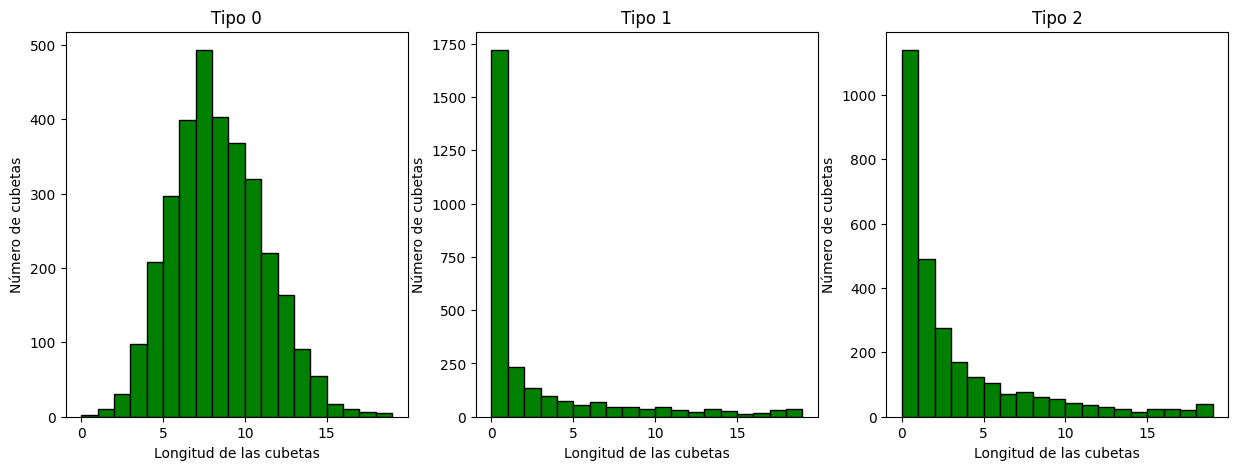

In [25]:

plt.figure(figsize=(15,5))
for i in (0,1,2):
    plt.subplot(1,3,i+1)
    plt.hist(list(cjt[i].longitudes_cubetas()),
                 bins=list(range(20)),
                 density=False,
                 histtype='bar',
                 color='g',
                 edgecolor='k'
                )
    plt.xlabel('Longitud de las cubetas')
    plt.ylabel('Número de cubetas')
    plt.title(f'Tipo {i}')

plt.show()

### Actividad 3.2

En vista de los histogramas de ocupación obtenidos ¿Cuál crees que es la mejor función de dispersión para estos datos? (Razona la respuesta)

> La mejor función de dispersión es la tipo 0 porque el numero de elementos de cada cubeta es similar, que es lo que se busca con una función de dispersión.


<a id='anexo1'></a>
## Anexo 1: Código de la clase `SeparateChainingHashTable`

```python
class SeparateChainingHashTable:
    def __init__(self, initial_table_size = 2**3):
        self._n = 0
        self._table = [[] for i in range(initial_table_size)]

    def __len__(self):
        return self._n

    def _hash_function(self, key):
        return hash(key) % len(self._table)

    def load_factor(self):
        return self._n / len(self._table)
        
    def __getitem__(self, key):
        index = self._hash_function(key)
        bucket_list = self._table[index]
        for (k, v) in bucket_list:
            if k == key:
                return v
        raise KeyError("Key Error: " + repr(key))

    def __contains__(self, key):
        index = self._hash_function(key)
        bucket_list = self._table[index]
        for (k, v) in bucket_list:
            if k == key:
                return True
        return False

    def __setitem__ (self, key, value):
        index = self._hash_function(key)
        bucket_list = self._table[index]
        for i,(k, v) in enumerate(bucket_list):
            if k == key:
                bucket_list[i] = (k, value)
                return
        bucket_list.append((key, value))
        self._n += 1
        if self.load_factor() >= 2:
            self._resize(2 * len(self._table))

    def __delitem__ (self, key):
        index = self._hash_function(key)
        bucket_list = self._table[index]
        pos = -1
        for i,(k, v) in enumerate(bucket_list):
            if k == key:
                pos = i
                break
        if pos == -1:
            raise KeyError("Key Error: " + repr(key))
        del bucket_list[pos]
        self._n -= 1

    def _resize(self, new_table_size):
        old_table = self._table
        self._table = [[] for i in range(new_table_size)]
        for bucket_list in old_table:
            for (k,v) in bucket_list:
                index = self._hash_function(k)
                self._table[index].append((k,v))

    def __iter__(self):
        for bucket_list in self._table:
            for (k,v) in bucket_list:
                yield k

    def __repr__(self):
        aux = []
        for bucket_list in self._table:
            for (k,v) in bucket_list:
                aux.append(repr(k)+":"+repr(v))
        return "{" + ",".join(aux) + "}"

```
